# Assessment of iQAir AirVisual Outdoor Particle and CO2 Sensors

September 2023

Jörg Klausen (MeteoSwiss, joerg.klausen@meteoswiss.ch), Recha Wambongo (University of Bomet County, Kenya), Constance Okuku (Kenya Meteorological Department, Bomet County, Kenya)

Disclaimer: The results obtained and views expressed in the following analysis solely reflect the views of the authors. They do not endorse the sensors under test. The affiliation of one of the authors with MeteoSwiss does not constitute any endorsement or recommendation on the part of MeteoSwiss. 

Acknowledgments: The iQAir AirVisual Outdoor sensors were purchased with funds from SCNAT ACP for use in an educational setting in Bomet County, Kenya. The company iQAIr provided free access to their dashboard.

## Introduction
This Jupyter notebook describes the steps taken to assess the behavior of three iQAir Outdoor Visual that were procured in spring 2023 following an expression of interest by the Kenya Meteorological Department and the University of Bomet County. The units are intended to be deployed in Nairobi and Bomet County, Kenya to provide a basic characterization the air quality for educational purposes. Given a choice between not having any measurements or utilizing a small fund to purchase and deploy instruments at the low cost end of the spectrum, the decision was made to give it a try. A certain reluctance towards the use of so-called "low-cost" sensors was based on their limited accuracy, precision and known potential for drift and cross-sensitivities [e.g., WMO, others]. 

## Choice of instrument
The decision to try out the iQAir Outdoor modules was based on data provided by the company that characterized the PM sensor module. These data comprised of a calibration made by Metas as well as comparisons made by the company itself [Frank Hammes, 2023, personal communication]. An important criterion was also the very modular design, easy deployment, and excellent integration of the data into the iQAir dahboard. The dashboard provides access to the data, all metadata, graphics of current and past measurements, as well as a TV view for display. The PM sensor module consists of a nephelometer (of unknown type), and the CO2 sensor module integrates a Senseair S8 LP sensor in auto-calibration mode. Initial reservations were due to the fact that the PM sensor is based on nephelometry and is not a single-particle optical particle sensor like the Sensirion SPS30. 
The modular design of the iQAir AirVisual Outdoor allows replacement of the individual sensor modules in a plug-and-play manner that is extremely convenient for users. Also, the instrument comes in a rugged white plastic case with mounting brackets facilitating wall-mounting as well as mounting on a pole. Further, WIFI, LAN and GSM-connectivity are supported. At the time of purchase, an iQAir AirVisual Outdoor sensor comprising of 2 PM and 1 CO2 sensor module and PoE adapter with 2 LAN cables of different lengths was sold for CHF 289. Replacement sensor modules were sold for CHF 99 each, and the GSM modem was CHF 59 (?).

## Setup
Between 19 July 2023 and 12 September 2023, the three units were installed on top of each other at the northern edge on the roof of the Nabel station Dübendorf (Swiss coordinates 2688299 / 1251109, elevation: 431.0 m) (cf. Table 1). All units were facing south and were partially shaded by other instrumentation about 1 m away to the south. The roof consists of grey concrete slabs. The Nabel station consists of a building of about 6 x 9 m2 and is situated in a suburban setting with a railway line and obstruction by buildings at a distance of 40-60 m. A small open creek runs to the south of the building (cf. [GIS browser Zurich](https://maps.zh.ch?topic=BASISKARTEZH&scale=716&x=2688298.04&y=1251096.46&srid=2056) for more details).

Unit|Distance from ground|Comment
---|---|---
X15A|3.0 m| 2 PM sensor modules (s/n 00000057692022422797, s/n 00000057692022173976), 1 CO2 sensor module (s/n 074a4d82000000000000)
WICH|3.4 m| 2 PM sensor modules (s/n 00000057692022174804, s/n 00000057692022880348), 1 CO2 sensor module (s/n 074a4fa7000000000000)
TWRG|3.8 m| 3 PM sensor modules (s/n 00000057691051732991, s/n 00000057692022174947, s/n 00000057692022420591), 1 CO2 sensor module (s/n 074a71f1000000000000)

## Data
The historical raw data in .CSV format were obtained directly from the dashboard. Two exports were needed to cover the entire period. The files were stitched together and saved. Hourly reference data of the Nabel station were downloaded as a .CSV file from the [FOEN web site](https://bafu.meteotest.ch/nabel/index.php/abfrage/start/german; accessed on 06 October 2023) and saved. NB: One line of Nabel data was commented out (24.08.2023 20:00;106.6;0.20;99.7;20.0;0.2;27.1;-3.2) as the high PM10 value of 99.7 ug/m3 was considered an outlier.
Reference CO2 data were kindly provided by Stuart Grange and Christoph Hüglin from Empa (cf. Table for more details).

Variable|Instrument|Temporal resolution|Comment
---|---|---|---
PM10 mass concentration|Fidas|hourly|
PM2.5 mass concentration|Fidas|hourly|
EC in PM2.5 mass concentration|Magee Aethalometer AE33 (?)|hourly|
Temperature|...?...|...|
CO2 mole fraction|Picarro G1301|1-minute|UTC
CO2 mole fraction in dry air|Picarro G1301|1-minute|UTC (not found in file?)

## Analysis
In order to prevent potential extreme values / outliers from influencing the analysis, sub-hourly data from the iQAir AirVisual Outdoor and Picarro instruments were aggregated by computing hourly median values.

TODO: plot RH of AirVisual and in CO2 plot and try to apply RH-correction to CO2 data

In [169]:
import os
import re
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

root = "C:/Users/localadmin/Documents/git/airvisual/"


In [170]:
# Read the AirVisual Outdoor file into a Polars DataFrame
def get_airvisual_data(root, instrument):
  path = os.path.join(root, f"data/historical_raw_data_airvisual_outdoor_{instrument}.csv")
  df_raw = pl.read_csv(path)

  # Extract timezone from Timezone column
  tz = re.findall(r".+UTC(.+)", df_raw["Timezone"][0])[0]

  # Convert dtm to UTC
  df_raw = df_raw.with_columns(df_raw["Datetime"].str.to_datetime(format=f"%Y-%m-%d %H:%M:%S", time_zone=tz).cast(pl.Datetime).alias("dtm"))

  # Drop the Timezone and Datetime columns
  df_raw = df_raw.drop("Timezone", "Datetime", "AQI US", "AQI CN", "Temperature (Fahrenheit)")

  # Fix column names
  df_raw = df_raw.rename({"Temperature (Celsius)": "Temp (°C)", "Humidity (%)": "RH (%)", "Pressure (pascal)": "Pres (Pa)"})

  # Sort data chronologically
  df_raw = df_raw.sort("dtm")

  # Loop through all columns and cast them to float
  for name, dtype in df_raw.schema.items():
      if dtype == pl.Float64:
        df_raw = df_raw.with_columns(df_raw[name].cast(pl.Float32))

  # Save the data in Parquet format
  df_raw.write_parquet(os.path.join("data", f"{instrument}_raw.parquet"))

  return df_raw

# Group by hour and calculate the median for numerical columns
def aggregate_data(df, every="1h"):
  df = df.groupby_dynamic("dtm",every=every).agg(pl.all().exclude('dtm').median())

  # Loop through all columns and cast them to float
  for name, dtype in df.schema.items():
      if dtype == pl.Float64:
        df = df.with_columns(df[name].cast(pl.Float32))

  return df

In [171]:
# Plot raw AirVisual particle data
def plot_raw_airvisual_pm_data(df, root, instrument):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["PM10 (ug/m3)"], label="PM10")
  plt.plot(df["dtm"], df["PM2.5 (ug/m3)"], label="PM2.5")
  plt.plot(df["dtm"], df["PM1 (ug/m3)"], label="PM1")
  plt.xlabel("dtm")
  plt.ylabel("Mass concentration (ug/m3)")
  plt.legend()
  plt.grid(True)
  plt.title(f'AirVisual Outdoor {instrument} raw data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_raw_pm.png"))

  # Show the interactive plot (optional)
  plt.show()

# Plot raw AirVisual carbon dioxide data
def plot_raw_airvisual_co2_data(df, root, instrument):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["CO2 (ppm)"], label="CO2")
  plt.xlabel("dtm")
  plt.ylabel("Mole fraction (ppm)")
  plt.legend()
  plt.grid(True)
  plt.title(f'AirVisual Outdoor {instrument} raw data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_raw_co2.png"))

  # Show the interactive plot (optional)
  plt.show()

# Generate an interactive plot
def plot_aggregated_airvisual_pm_data(df, instrument, root):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["PM10 (ug/m3)"], label="PM10")
  plt.plot(df["dtm"], df["PM2.5 (ug/m3)"], label="PM2.5")
  plt.plot(df["dtm"], df["PM1 (ug/m3)"], label="PM1")
  plt.xlabel("dtm")
  plt.ylabel("Mass concentration (ug/m3)")
  plt.legend()
  plt.grid(True)
  plt.title(f'AirVisual Outdoor {instrument} raw data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_raw.png"))

  # Show the interactive plot (optional)
  plt.show()


In [172]:
# Read the Nabel data into a polars dataframe
def get_nabel_pm_data(path):
  df = pl.read_csv(source=path, has_header=True, separator=";", skip_rows=6, comment_char="#")

  # Convert dtm to ISO8601. CET is not understood and Europe/Zurich applies DST
  df = df.with_columns(df["Datum/Zeit"].str.to_datetime(format=f"%d.%m.%Y %H:%M", time_zone='UTC').cast(pl.Datetime))
  df = df.with_columns(df["Datum/Zeit"].dt.offset_by("-1h").alias("dtm"))

  # Fix column names
  df = df.rename({"PM10 [ug/m3]": "PM10ref (ug/m3)", "PM2.5 [ug/m3]": "PM2.5ref (ug/m3)", "EC [ug/m3]": "EC in PM2.5 (ug/m3)", "TEMP [C]": "Temp (°C)", "RAD [W/m2]": "GloRad (W/m2)"})

  # Drop Datum/Zeit column
  df = df.drop("Datum/Zeit")

  # Sort data chronologically
  df = df.sort("dtm")

  # Loop through all columns and cast them to float
  for name, dtype in df.schema.items():
      if dtype == pl.Float64:
        df = df.with_columns(df[name].cast(pl.Float32))

  # Save the data in Parquet format
  df.write_parquet(os.path.join("data", f"Nabel_PM_1h.parquet"))

  return df

# Read the Nabel data into a polars dataframe
def get_nabel_co2_data(path):
  df = pl.read_csv(source=path, has_header=True, separator=",", skip_rows=0, comment_char="#")

  # Convert dtm to ISO8601.
  df = df.with_columns(df["date"].str.to_datetime(format=f"%Y-%m-%d %H:%M:%S", time_zone='UTC').cast(pl.Datetime))
  
  # Fix column names
  df = df.rename({"value": "CO2ref (ppm)", "date": "dtm"})

  # Drop date and other columns
  df = df.drop(["site","site_name","variable","sensor_id","sensor_type","unit"])

  # Sort data chronologically
  df = df.sort("dtm")

  # Loop through all columns and cast them to float
  for name, dtype in df.schema.items():
      if dtype == pl.Float64:
        df = df.with_columns(df[name].cast(pl.Float32))

  # Save the data in Parquet format
  df.write_parquet(os.path.join("data", f"Nabel_co2_1m.parquet"))

  return df


In [173]:
# Plot Nabel PM (Fidas) data
def plot_nabel_pm_data(df, root):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["PM10ref (ug/m3)"], label="PM10 Fidas")
  plt.plot(df["dtm"], df["PM2.5ref (ug/m3)"], label="PM2.5 Fidas")
  plt.xlabel("Datetime")
  plt.ylabel("Mass concentration (ug/m3)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Nabel Fidas 1-hourly mean data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"Nabel_Fidas_1h.png"))

  # Show the interactive plot (optional)
  plt.show()

# Plot Nabel CO2 (Picarro) data
def plot_nabel_co2_data(df, root, resolution="1m"):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["CO2ref (ppm)"], label="CO2 Picarro")
  plt.xlabel("Datetime")
  plt.ylabel("Mole fraction (ppm)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Nabel Picarro {resolution} data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"Nabel_Picarro_{resolution}.png"))

  # Show the interactive plot (optional)
  plt.show()

In [174]:
# Plot AirVisual PM vs Nabel PM data (time series)
def plot_airvisual_vs_nabel_pm_data(df, root, instrument):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["PM10ref (ug/m3)"], label="PM10 Fidas")
  plt.plot(df["dtm"], df["PM2.5ref (ug/m3)"], label="PM2.5 Fidas")
  plt.plot(df["dtm"], df["PM10 (ug/m3)"], label=f"PM10 {instrument}")
  plt.plot(df["dtm"], df["PM2.5 (ug/m3)"], label=f"PM2.5 {instrument}")
  plt.xlabel("Datetime")
  plt.ylabel("Mass concentration (ug/m3)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Airvisual Outdoor vs Nabel Fidas 1-hourly mean data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_vs_Nabel_Fidas_1h.png"))

  # Show the interactive plot (optional)
  plt.show()


In [175]:
# Plot Airvisual PM vs Nabel PM data (correlation)
def scatter_plot_airvisual_vs_nabel_pm(df, root,  instrument):
  plt.figure(figsize=(7, 6))
  plt.scatter(df["PM10ref (ug/m3)"], df["PM10 (ug/m3)"], label="PM10")
  plt.scatter(df["PM2.5ref (ug/m3)"], df["PM2.5 (ug/m3)"], label="PM2.5")
  plt.xlabel("Mass concentration Fidas (ug/m3)")
  plt.ylabel(f"Mass concentration {instrument} (ug/m3)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Airvisual Outdoor vs Nabel Fidas 1-hourly mean data')
  # plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_vs_Nabel_Fidas_1h.png"))

  # Show the interactive plot (optional)
  plt.show()

# Plot ratio of Airvisual PM vs Nabel PM data  (time series)
def plot_airvisual_vs_nabel_pm_ratios(df, root, instrument):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["PM10 ratio"], label=f"PM10 {instrument} / PM10 Fidas")
  plt.plot(df["dtm"], df["PM2.5 ratio"], label=f"PM2.5 {instrument} / PM2.5 Fidas")
  plt.xlabel("Datetime")
  plt.ylabel("Mass concentration ratio (1)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Airvisual Outdoor vs Nabel Fidas 1-hourly mean data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_vs_Nabel_Fidas__ratio_1h.png"))

  # Show the interactive plot (optional)
  plt.show()

In [176]:
# Plot AirVisual CO2 vs Nabel CO2 data (time series)
def plot_airvisual_vs_nabel_co2_data(df, root, instrument):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["CO2ref (ppm)"], label="CO2 Picarro")
  plt.plot(df["dtm"], df["CO2 (ppm)"], label=f"CO2 {instrument}")
  plt.xlabel("Datetime")
  plt.ylabel("CO2 mole fraction (ppm)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Airvisual Outdoor vs Nabel Picarro 1-hourly mean data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_vs_Nabel_Picarro_1h.png"))

  # Show the interactive plot (optional)
  plt.show()

# Generate an interactive plot
def plot_airvisual_vs_nabel_co2_ratios(df, root, instrument):
  plt.figure(figsize=(12, 6))
  plt.plot(df["dtm"], df["CO2 ratio"], label=f"CO2 {instrument} / CO2 Picarro")
  plt.xlabel("Datetime")
  plt.ylabel("CO2 mole fraction ratio (1)")
  plt.legend()
  plt.grid(True)
  plt.title(f'Airvisual Outdoor vs Nabel Picarro 1-hourly mean data')
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_vs_Nabel_Picarro_ratio_1h.png"))

  # Show the interactive plot (optional)
  plt.show()


In [177]:
# Perform linear regression
def generate_plot_polyfit(df, root, instrument, variable, unit) -> tuple():
  # remove NaN
  df = df.drop_nulls()
  
  # Extract X and Y columns as NumPy arrays
  X = df[f"{variable}ref ({unit})"].to_numpy()
  Y = df[f"{variable} ({unit})"].to_numpy()

  # Perform linear regression using NumPy
  model = np.polyfit(X, Y, 1)
  slope, intercept = model
  predict = np.poly1d(model)
  r2 = r2_score(Y, predict(X))

  # Create the regression line equation as a string
  regression_equation = f"{variable} ({unit}) = {slope:.2f} x {variable}ref ({unit}) + {intercept:.2f} ({unit})"

  # Create the regression line (Y values) based on the regression equation
  regression_line = slope * X + intercept

  # Create a scatter plot of the data points
  plt.figure(figsize=(8, 6))
  plt.scatter(X, Y, label=f"{variable}")

  # Plot the regression line
  plt.plot(X, regression_line, label=f"Regression Line\n{regression_equation}", color='black')

  # Plot the 1:1 line
  plt.plot((min(X), max(X)), (min(X), max(X)), label=f"1:1 line", color="red", linestyle=":")

  # Add labels and legend
  plt.xlabel(f"{variable}ref ({unit})")
  plt.ylabel(f"{variable} ({unit})")
  plt.legend()

  # Show the plot
  plt.show()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"{instrument}_vs_Nabel_{variable}_1h_regression.png"))

  # Print the regression parameters
  print(f"Regression Parameters for {instrument} vs Nabel:")
  print(f" - Slope (Coefficient): {slope:.2f}")
  print(f" - Intercept: {intercept:.2f}")
  print(f" - r2: {r2:.2f}")
  return (instrument, variable, slope, intercept, r2)

In [178]:
def process_instrument_data(root, instrument, df_nabel_pm, df_nabel_co2) -> tuple():
  # get AirVisual data and plot raw data
  df = get_airvisual_data(root, instrument)
  plot_raw_airvisual_pm_data(df, root, instrument)
  plot_raw_airvisual_co2_data(df, root, instrument)
  df_1h = aggregate_data(df)

  # Join dataframes on dtm
  df = df_nabel_pm.join(df_1h, on="dtm")
  df = df.join(df_nabel_co2, on="dtm")
  df = df.with_columns((pl.col("PM10 (ug/m3)") / pl.col("PM10ref (ug/m3)")).alias("PM10 ratio"))
  df = df.with_columns((pl.col("PM2.5 (ug/m3)") / pl.col("PM2.5ref (ug/m3)")).alias("PM2.5 ratio"))
  df = df.with_columns((pl.col("CO2 (ppm)") / pl.col("CO2ref (ppm)")).alias("CO2 ratio"))

  # plot Airvisual vs Nabel PM data
  plot_airvisual_vs_nabel_pm_data(df=df, root=root, instrument=instrument)
  plot_airvisual_vs_nabel_pm_ratios(df, root, instrument)
  # scatter_plot_airvisual_vs_nabel_pm(df, root,  instrument)
  
  variable = "PM10"
  pm10_fit = generate_plot_polyfit(df, root, instrument, variable, unit="ug/m3")
  variable = "PM2.5"
  pm25_fit = generate_plot_polyfit(df, root, instrument, variable, unit="ug/m3")

  # plot Airvisual vs Nabel CO2 data
  plot_airvisual_vs_nabel_co2_data(df=df, root=root, instrument=instrument)
  plot_airvisual_vs_nabel_co2_ratios(df, root, instrument)

  variable = "CO2"
  co2_fit = generate_plot_polyfit(df, root, instrument, variable, unit="ppm")

  return (pm10_fit, pm25_fit, co2_fit)


In [179]:
# Plot Airvisual PM vs Nabel PM
def scatter_plot_fitting_results(root, twrg, wich, x15a):
  fig, ax1 = plt.subplots(figsize=(6, 6))
  ax1.scatter(twrg[0][2], twrg[0][3], label="TWRG PM10", facecolors='blue', edgecolors='blue', s=100/twrg[0][4])
  ax1.scatter(wich[0][2], wich[0][3], label="WICH PM10", facecolors='green', edgecolors='green', s=100/wich[0][4])
  ax1.scatter(x15a[0][2], x15a[0][3], label="X15A PM10", facecolors='red', edgecolors='red', s=100/x15a[0][4])
  ax1.scatter(twrg[1][2], twrg[1][3], label="TWRG PM25", facecolors='none', edgecolors="blue", s=100/twrg[1][4])
  ax1.scatter(wich[1][2], wich[1][3], label="WICH PM25", facecolors='none', edgecolors="green", s=100/wich[1][4])
  ax1.scatter(x15a[1][2], x15a[1][3], label="X15A PM25", facecolors='none', edgecolors="red", s=100/x15a[1][4])

  ax2 = ax1.twinx()
  ax2.scatter(twrg[2][2], twrg[2][3], label="TWRG CO2", color="blue", marker="+", s=100/twrg[2][4])
  ax2.scatter(wich[2][2], wich[2][3], label="WICH CO2", color="green", marker="+", s=100/wich[2][4])
  ax2.scatter(x15a[2][2], x15a[2][3], label="X15A CO2", color="red", marker="+", s=100/x15a[2][4])

  # # Align the y-axes so that 0 is the same for both axes
  y1 = (-1.5, 1.5)
  y2 = (-15, 15)
  ax1.set_ylim((min(y1), max(y1)))
  ax2.set_ylim(min(y2), max(y2))

  # # Combine legends from both axes
  # lines, labels = ax1.get_legend_handles_labels()
  # lines2, labels2 = ax2.get_legend_handles_labels()
  # ax2.legend(lines + lines2, labels + labels2, loc='upper right')

  ax1.set_xlabel("Slope")
  ax1.set_ylabel(f"Intercept PM (ug/m3)")
  ax2.set_ylabel(f"Intercept CO2 (ppm)")
  ax1.legend()
  ax2.legend()

  # Draw lines at x, y=0
  ax1.axhline(y=0, color='k', linestyle='--')
  ax1.axvline(x=1, color='k', linestyle='--')

  # plt.grid(True)
  plt.title(f'Airvisual Outdoor vs Nabel 1-hourly mean data')
  plt.tight_layout()

  # Save the plot to a PNG file
  plt.savefig(os.path.join(root, "figures", f"Fits_AirVisual_vs_Nabel_1h.png"))

  # Show the interactive plot (optional)
  plt.show()

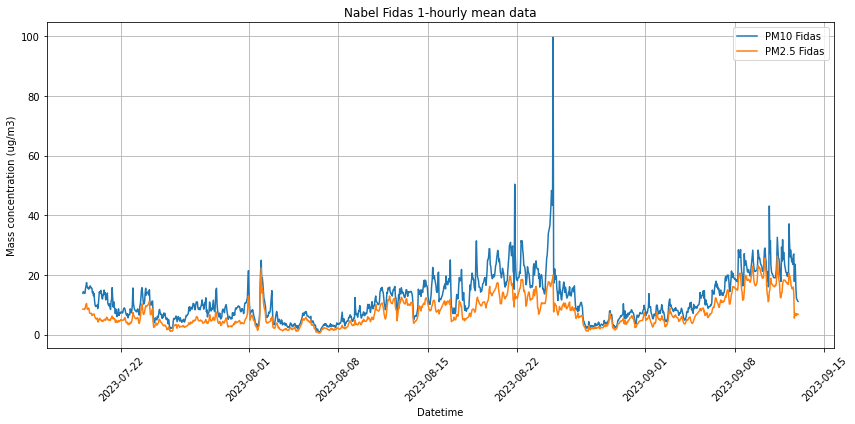

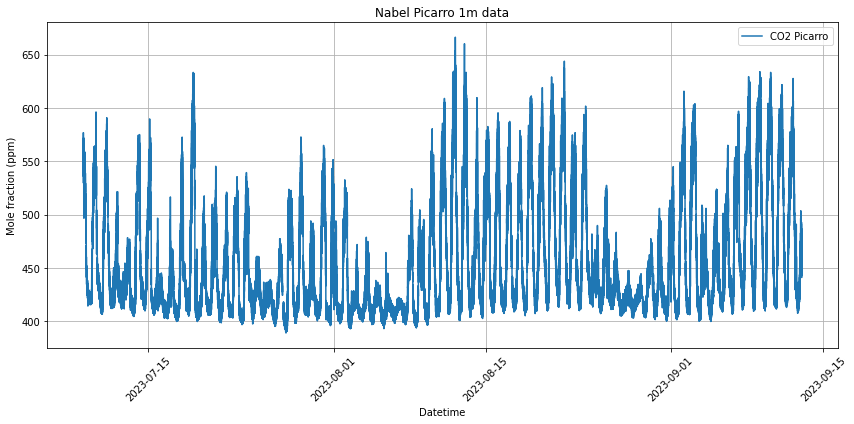

In [180]:
# get Nabel PM data
path = os.path.join(root, f"data/nabel_pm_1h.csv")
df_nabel_pm = get_nabel_pm_data(path)
plot_nabel_pm_data(df_nabel_pm, root)

# get Nabel CO2 data
path = os.path.join(root, f"data/nabel_co2_1m.csv")
df_nabel_co2_raw = get_nabel_co2_data(path)
plot_nabel_co2_data(df_nabel_co2_raw, root, "1m")
df_nabel_co2 = aggregate_data(df_nabel_co2_raw)


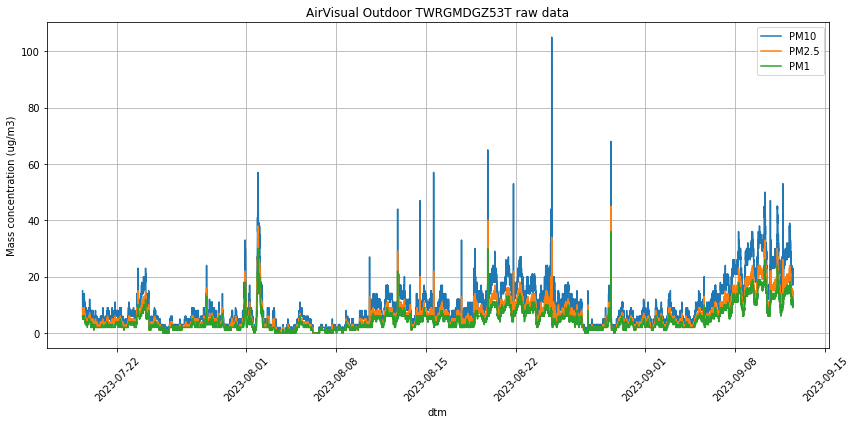

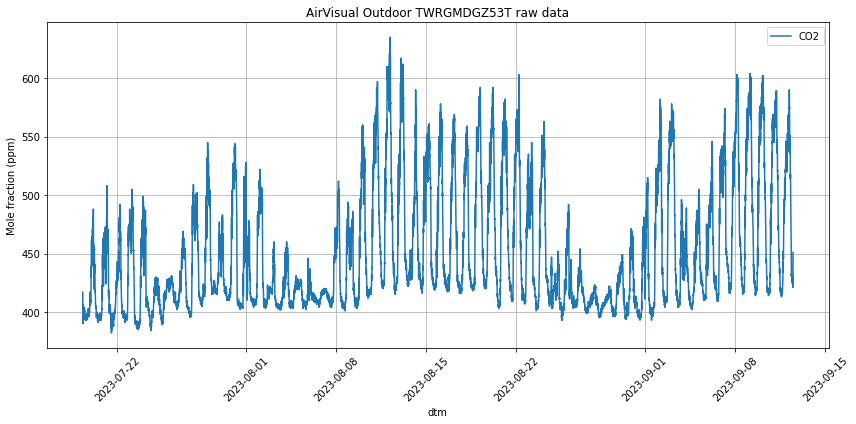

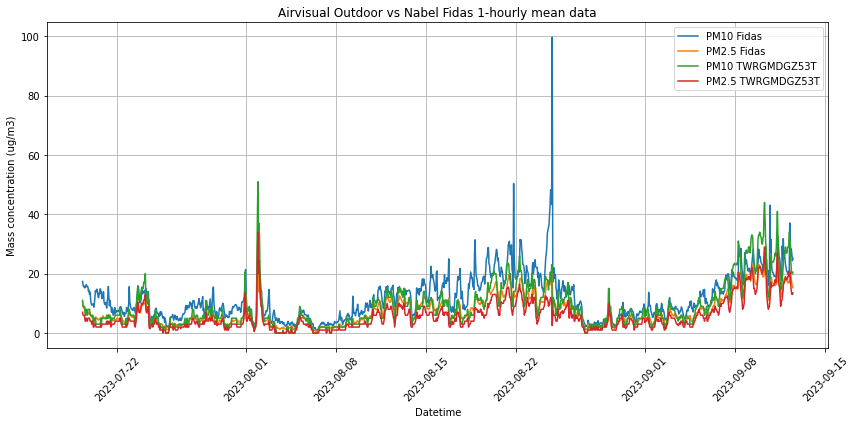

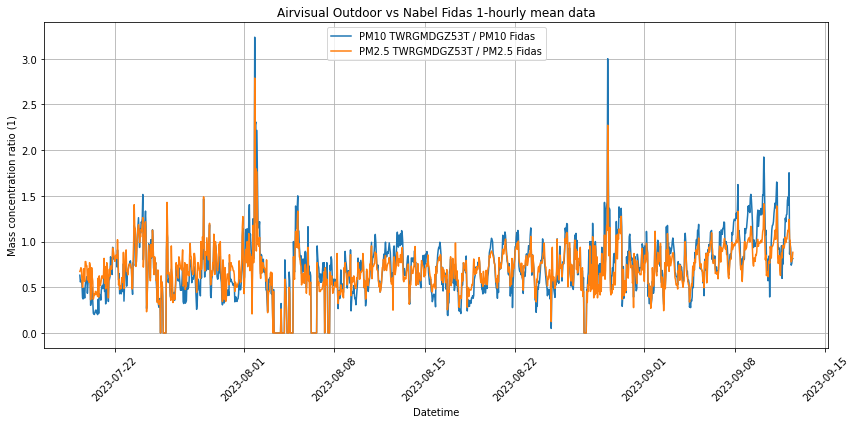

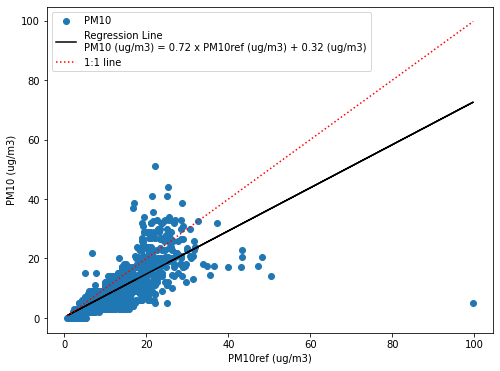

Regression Parameters for TWRGMDGZ53T vs Nabel:
 - Slope (Coefficient): 0.72
 - Intercept: 0.32
 - r2: 0.56


<Figure size 432x288 with 0 Axes>

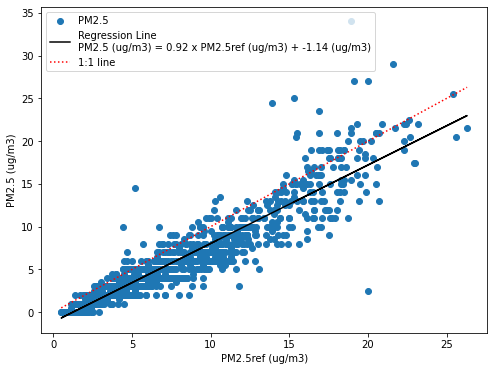

Regression Parameters for TWRGMDGZ53T vs Nabel:
 - Slope (Coefficient): 0.92
 - Intercept: -1.14
 - r2: 0.86


<Figure size 432x288 with 0 Axes>

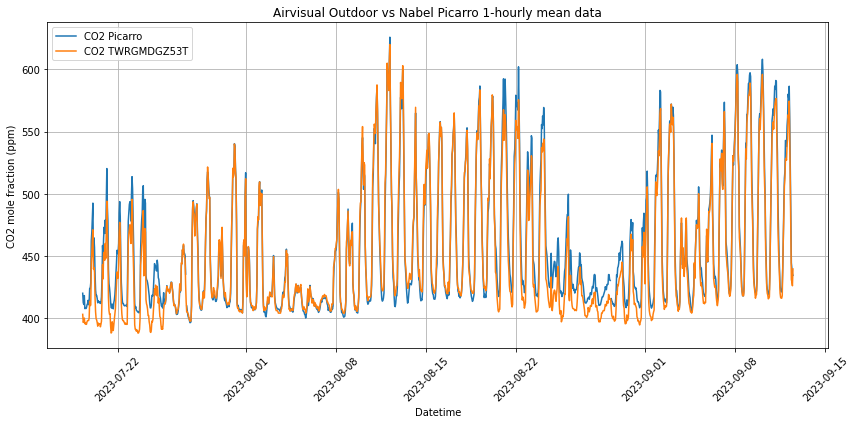

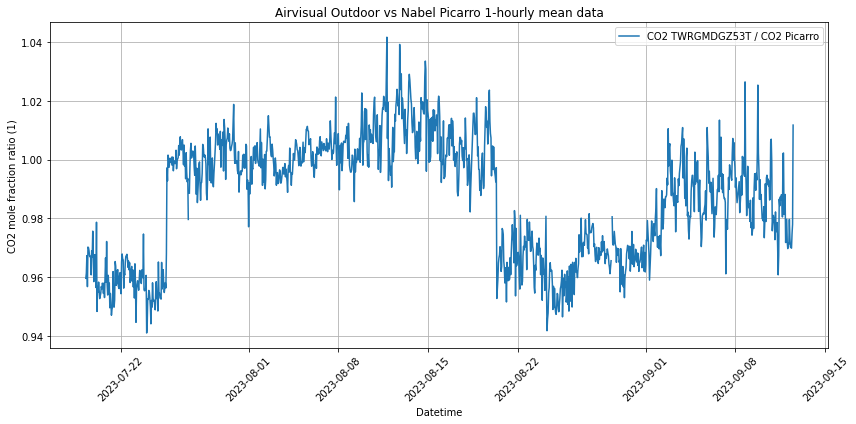

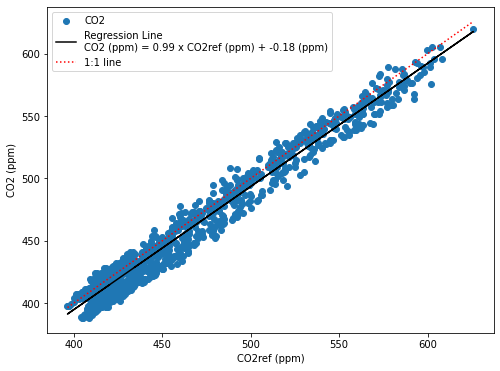

Regression Parameters for TWRGMDGZ53T vs Nabel:
 - Slope (Coefficient): 0.99
 - Intercept: -0.18
 - r2: 0.97


<Figure size 432x288 with 0 Axes>

In [181]:
instrument = "TWRGMDGZ53T"
twrg = process_instrument_data(root, instrument, df_nabel_pm, df_nabel_co2)


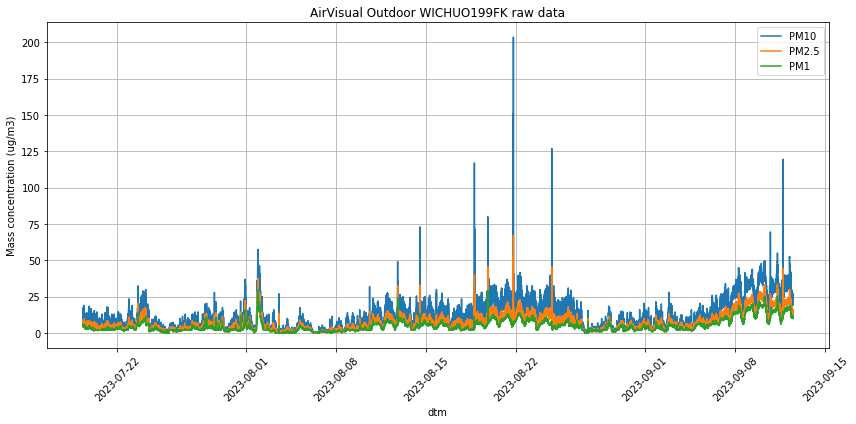

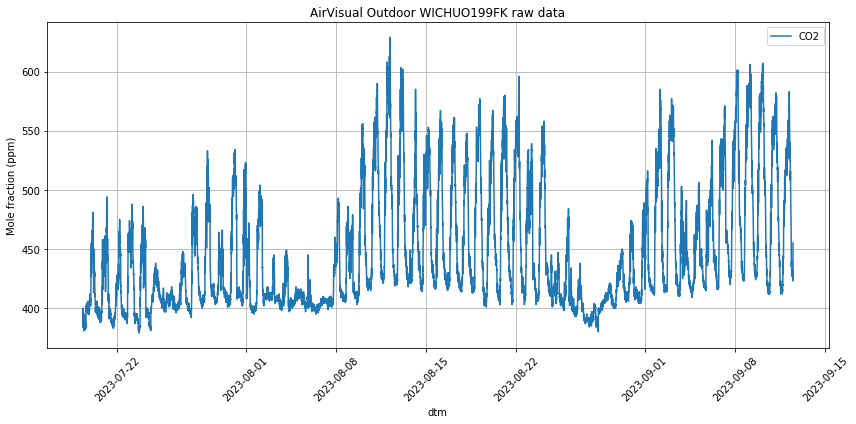

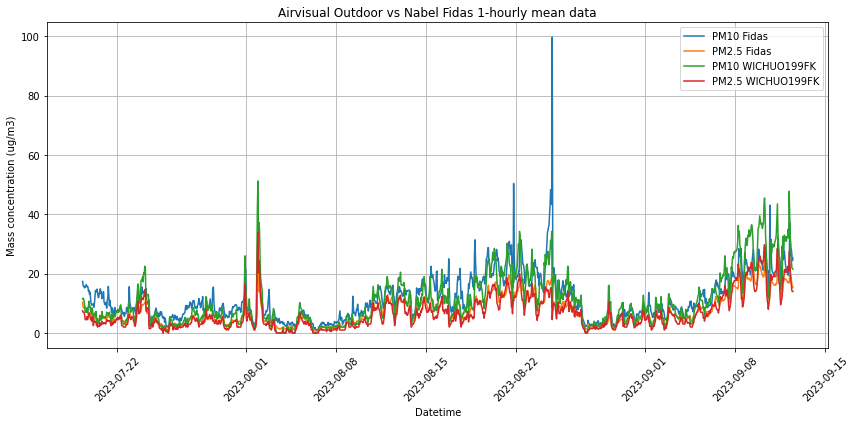

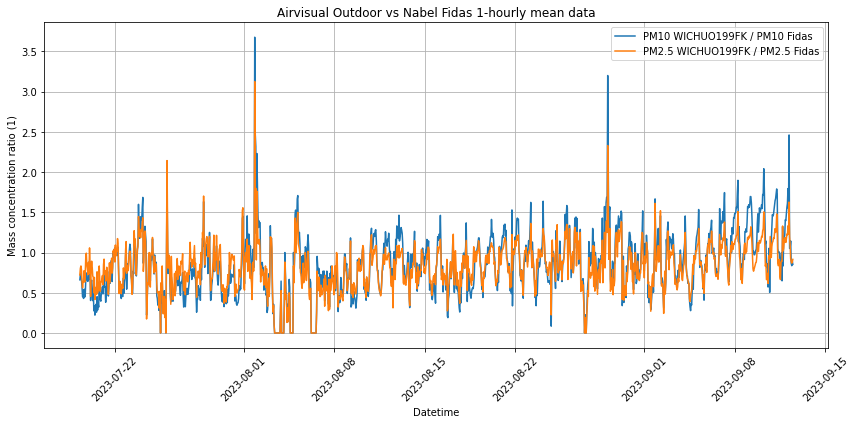

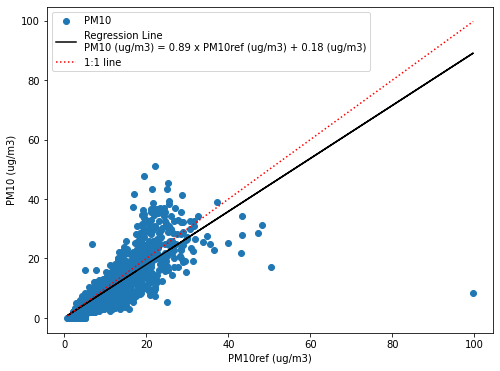

Regression Parameters for WICHUO199FK vs Nabel:
 - Slope (Coefficient): 0.89
 - Intercept: 0.18
 - r2: 0.61


<Figure size 432x288 with 0 Axes>

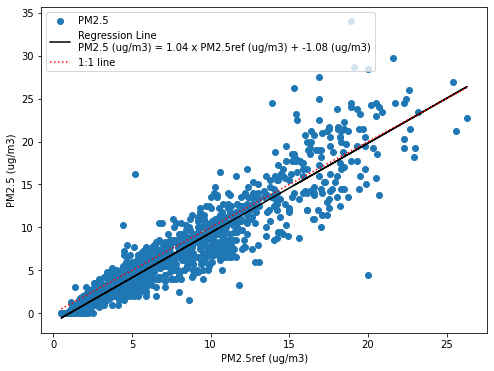

Regression Parameters for WICHUO199FK vs Nabel:
 - Slope (Coefficient): 1.04
 - Intercept: -1.08
 - r2: 0.86


<Figure size 432x288 with 0 Axes>

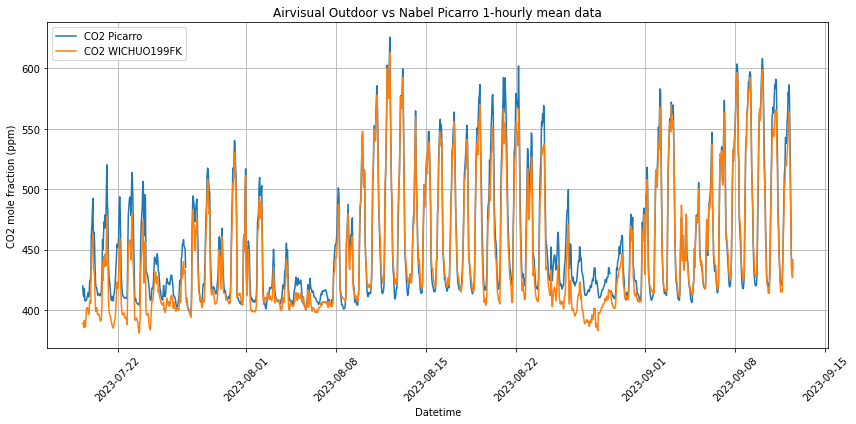

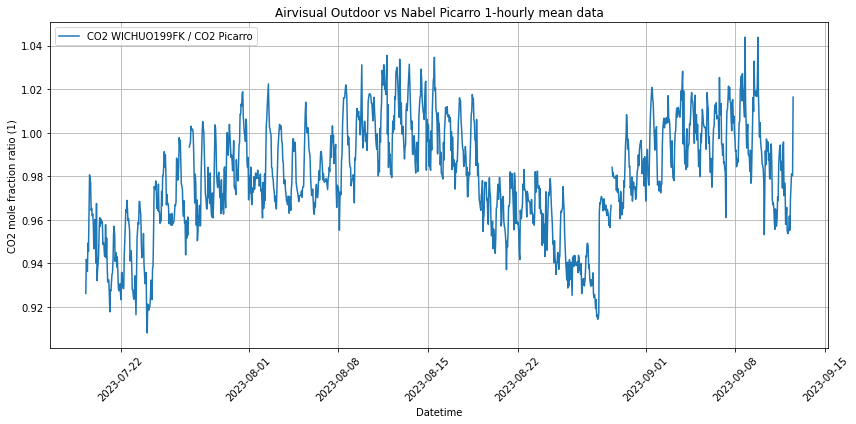

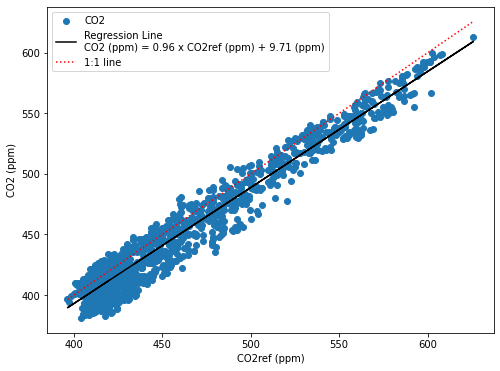

Regression Parameters for WICHUO199FK vs Nabel:
 - Slope (Coefficient): 0.96
 - Intercept: 9.71
 - r2: 0.95


<Figure size 432x288 with 0 Axes>

In [182]:
instrument = "WICHUO199FK"
wich = process_instrument_data(root, instrument, df_nabel_pm, df_nabel_co2)

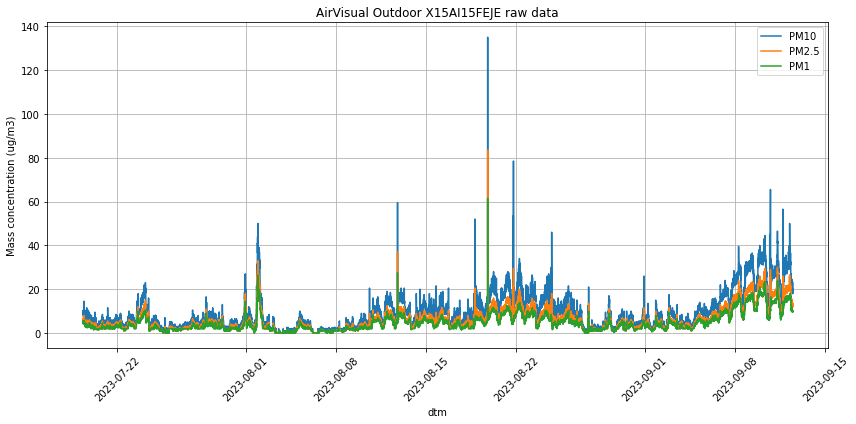

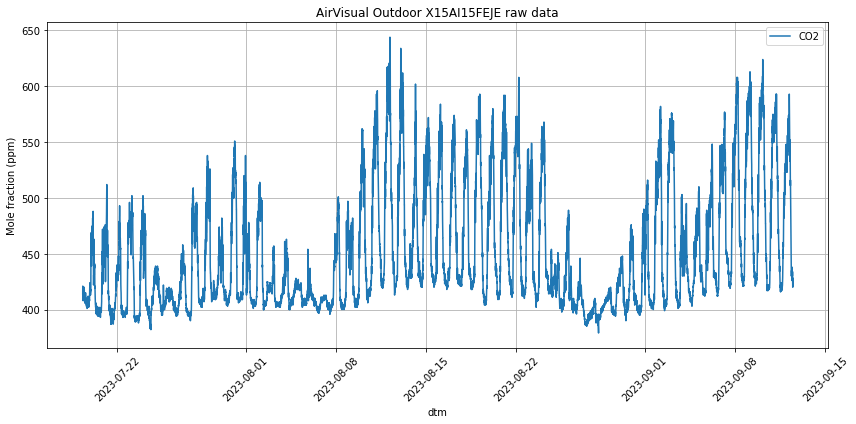

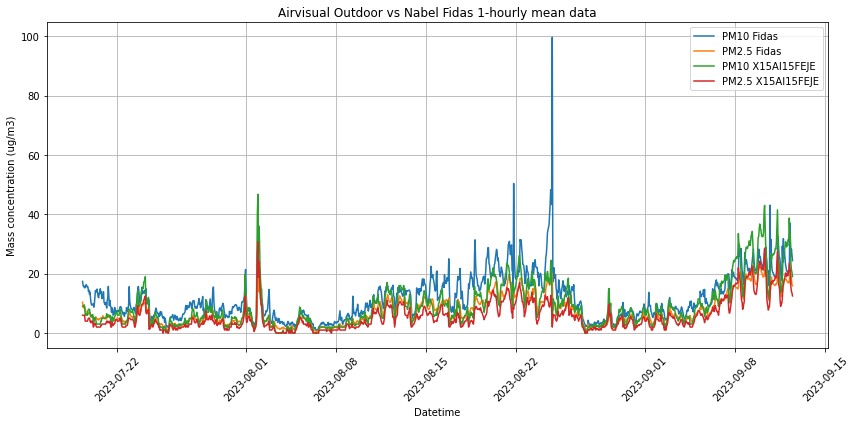

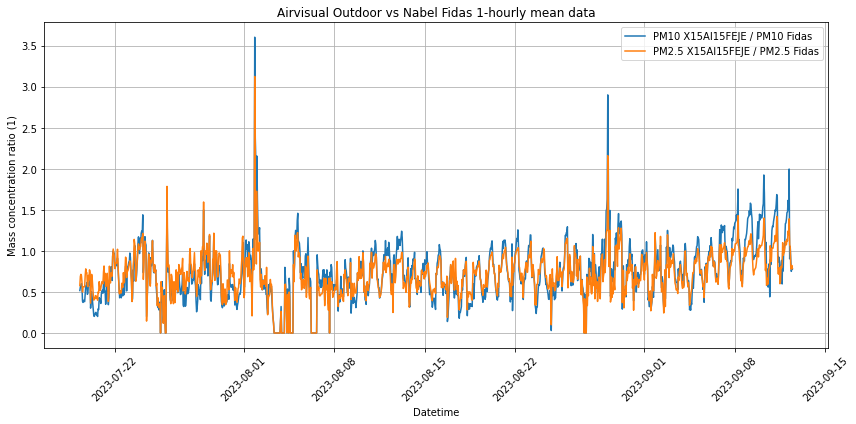

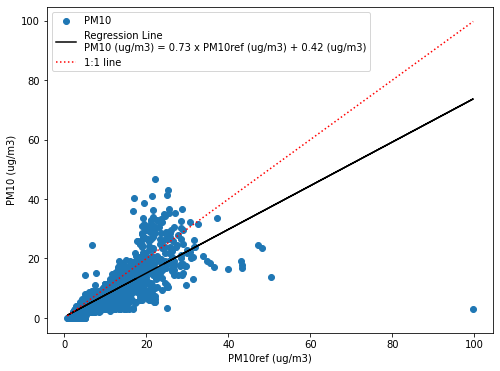

Regression Parameters for X15AI15FEJE vs Nabel:
 - Slope (Coefficient): 0.73
 - Intercept: 0.42
 - r2: 0.54


<Figure size 432x288 with 0 Axes>

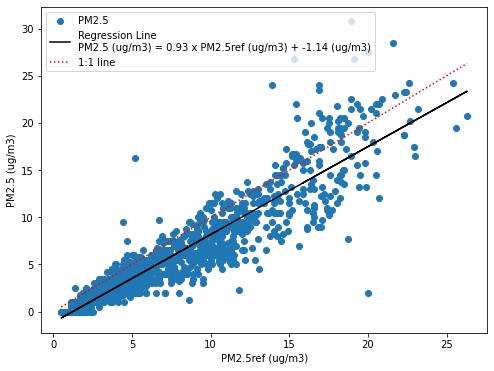

Regression Parameters for X15AI15FEJE vs Nabel:
 - Slope (Coefficient): 0.93
 - Intercept: -1.14
 - r2: 0.84


<Figure size 432x288 with 0 Axes>

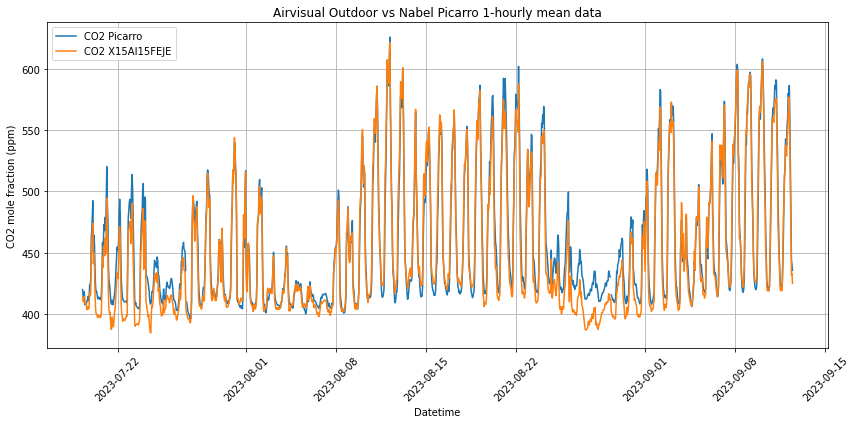

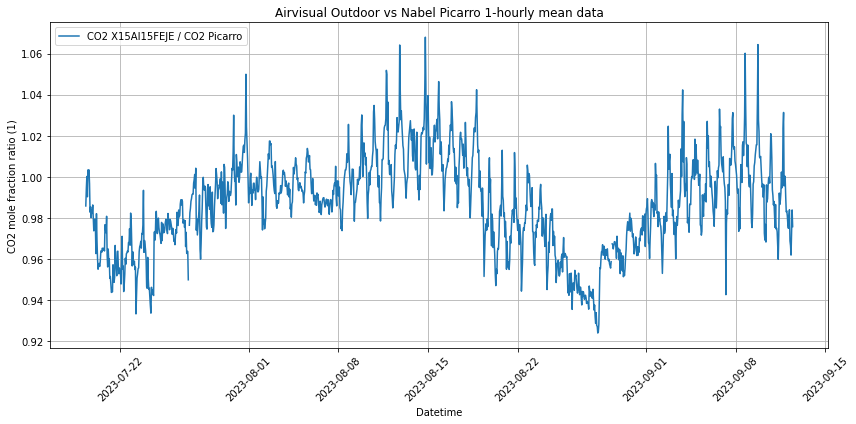

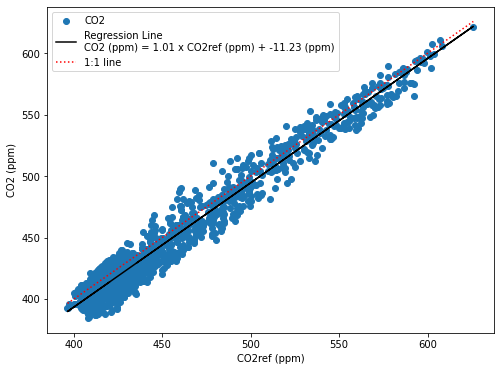

Regression Parameters for X15AI15FEJE vs Nabel:
 - Slope (Coefficient): 1.01
 - Intercept: -11.23
 - r2: 0.96


<Figure size 432x288 with 0 Axes>

In [183]:
instrument = "X15AI15FEJE"
x15a = process_instrument_data(root, instrument, df_nabel_pm, df_nabel_co2)

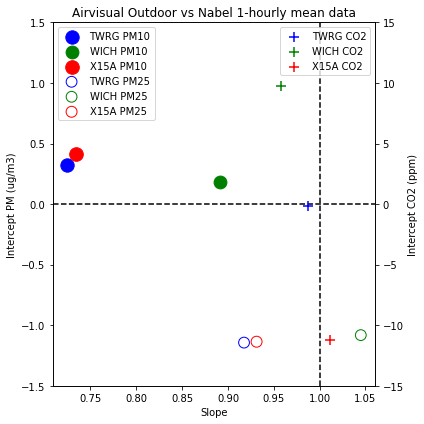

(('TWRGMDGZ53T', 'PM10', 0.7246571662976846, 0.3210667565323296, 0.5607274811067873), ('TWRGMDGZ53T', 'PM2.5', 0.9175576109197426, -1.1433592576479539, 0.8583868556927576), ('TWRGMDGZ53T', 'CO2', 0.9873745920382683, -0.1788380806342167, 0.9691794156457898)) (('WICHUO199FK', 'PM10', 0.8914172988439305, 0.182358826855556, 0.6072350546889362), ('WICHUO199FK', 'PM2.5', 1.0449637525582678, -1.081670436609847, 0.8607959596204202), ('WICHUO199FK', 'CO2', 0.9580607973353606, 9.709392285373054, 0.9514160103450154)) (('X15AI15FEJE', 'PM10', 0.7345535749689993, 0.41512404846001844, 0.540784734484654), ('X15AI15FEJE', 'PM2.5', 0.9312473084596973, -1.1360104202485328, 0.8380083352051643), ('X15AI15FEJE', 'CO2', 1.0116193492637442, -11.227906038914192, 0.962451775064024))


In [184]:
scatter_plot_fitting_results(root, twrg, wich, x15a)
print(twrg, wich, x15a)